<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Константы" data-toc-modified-id="Константы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Константы</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Загрузка-датасета,-ресеплирование" data-toc-modified-id="Загрузка-датасета,-ресеплирование-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Загрузка датасета, ресеплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

### Import

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     TimeSeriesSplit, 
                                     cross_val_score
                                    )
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

### Константы

In [2]:
RANDOM_STATE = 42

### Функции

In [3]:
### Функция добавления признаков в датасет и его разбиения на трейн, валидацию и тест

### На вход принимает имя датасета, максимальный лаг и "окно" скользящего среднего

### На выходе возвращает выборки для обучения, валидации и теста 
### на основе измененного датасета с добавленными признаками


def make_sets(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag, fill_value=0)
    data['roll_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    
    
    train, test = train_test_split(data, test_size=0.1, shuffle=False)
    X_train = train.drop('num_orders', axis=1)
    X_test = test.drop('num_orders', axis=1)
    y_train = train['num_orders']
    y_test = test['num_orders']
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    


### Загрузка датасета, ресеплирование

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.index.is_monotonic

True

Произведем ресеплирование датасета по 1 часу

In [8]:
data = data.resample('1H').sum()

Проверим сортировку и результат ресеплирования.

In [9]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

## Анализ

Для анализа построим графики временного ряда, скользящего среднего, тренда, сезонности и шума.

In [10]:
data['roll_mean'] = data.rolling(24).mean()

In [11]:
data.fillna(method='bfill', inplace=True)

In [12]:
decomposed = seasonal_decompose(data['num_orders'])

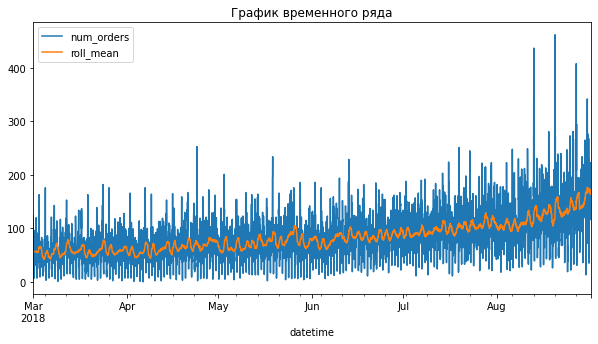

In [13]:
data.plot(figsize=(10,5), title='График временного ряда');

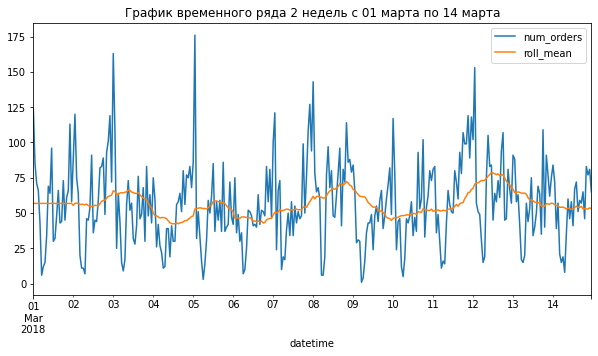

In [14]:
data['2018-03-01':'2018-03-14'].plot(figsize=(10,5), 
                                     title='График временного ряда 2 недель с 01 марта по 14 марта'
                                    );

Судя распределению - в некоторые дни наблюдаются пиковые значения. Например, в первую неделю - это определенно пятница, во вторую - пн и пт. Можно предположить, количество заказов в определенные дни стабильно выше, чем в остальные. Для этого включим в выборку признак дня недели (dayofweek).

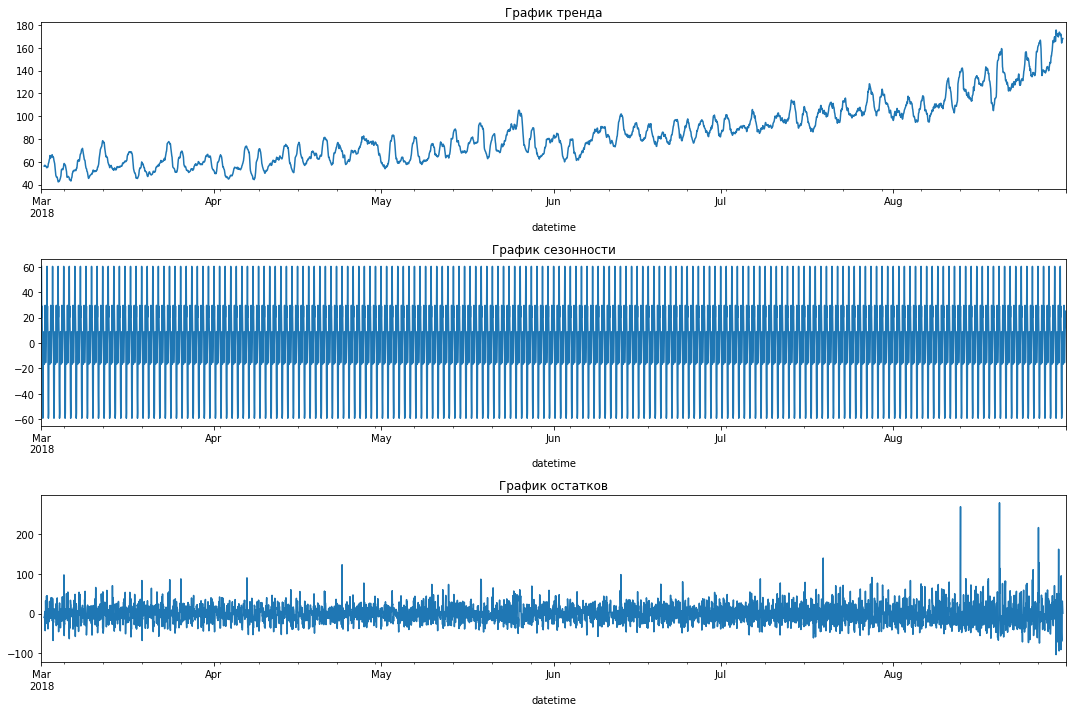

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('График тренда')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('График сезонности')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('График остатков')
plt.tight_layout()

Уточним график сезонности. Выведем информацию по 7 дням.

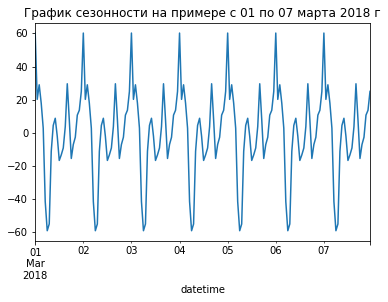

In [16]:
decomposed.seasonal['2018-03-01' : '2018-03-07'].plot(
    title='График сезонности на примере с 01 по 07 марта 2018 г'
);

А так же рассмотрим сезонность одного дня.

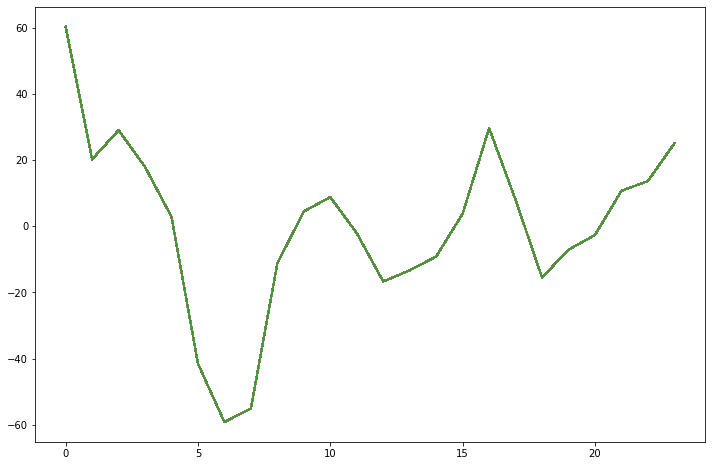

In [20]:
fig = plt.figure(figsize=(12, 8))
counter = 24
while counter < decomposed.seasonal.shape[0]:
    plt.plot(decomposed.seasonal[counter-24:counter].reset_index(drop=True), figure=fig)
    counter += 24 

Для определение стационарности добавим на график скользящее стандартное отклонение.

In [17]:
data['roll_std'] = data['num_orders'].rolling(24).std()

In [18]:
data.fillna(method='bfill', inplace=True)

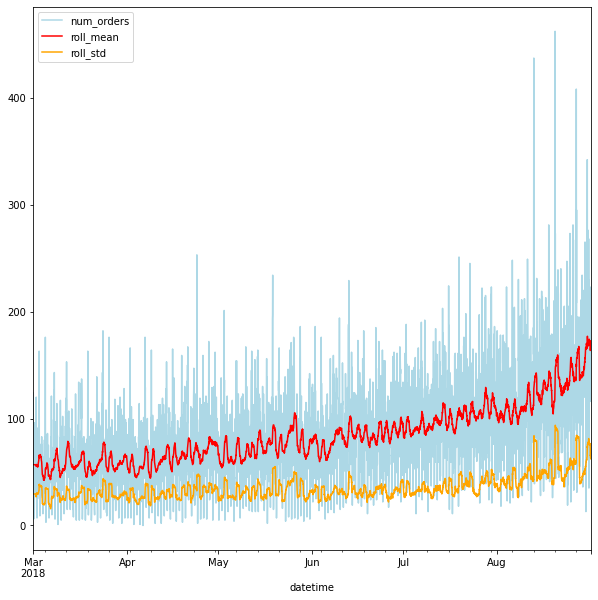

In [19]:
data.plot(figsize=(10,10), color=['lightblue', 'red', 'orange']);

По графикам можно сделать следующие выводы:
- В распределении ряда присутствует сезонность - 24 часа
- Cпрос на такси возрастает в конце дня, а затем падает в ранние утреннние часы
- Временной ряд не стационарен, т.к. скользящие средние и стандартные отклонения изменияются.

Для получения стационарного ряда, вычислим разность временного ряда первого порядка.

In [ ]:
data_diff = data.diff(periods=1).dropna()

In [22]:
data_diff.shape

(4415, 3)

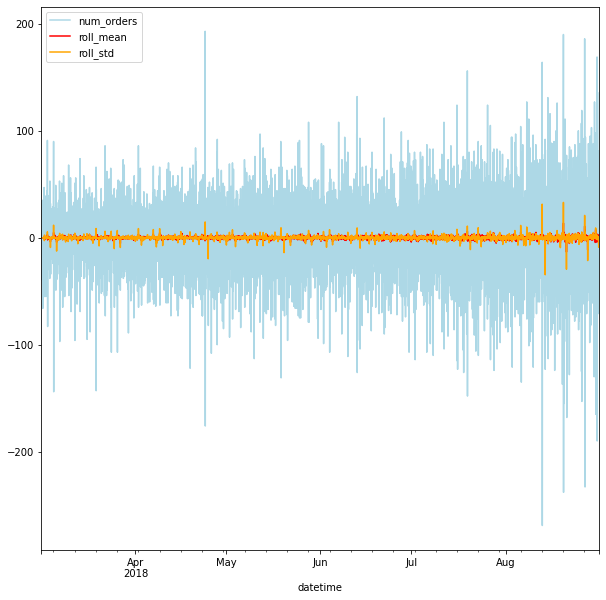

In [23]:
data_diff.plot(figsize=(10,10), color=['lightblue', 'red', 'orange']);

После преобразования получили стационарный ряд ,с которым и будем работать.

## Обучение

Обучим модели.

In [31]:
best_RMSE_lr = 48 # по условию задачи
best_params_lr = []

for i in range(1, 1000, 250):
    for j in range (1, 1000, 250):
        X_train, y_train, X_valid, y_valid, X_test, y_test = make_sets(data_diff, i, j)
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        RMSE_lr = mean_squared_error(model_lr.predict(X_valid), y_valid, squared=False)
        if RMSE_lr < best_RMSE_lr:
            best_model_lr = model_lr
            best_RMSE_lr = RMSE_lr
            best_params_lr = [i, j]
            
            
print('RMSE на валидации линейной регрессии - ', best_RMSE_lr, 'на параметрах: лаги - ', 
     best_params_lr[0], ', окно скользящего среднего - ', best_params_lr[1])

RMSE на валидации линейной регрессии -  24.793904357325964 на параметрах: лаги -  251 , окно скользящего среднего -  1


In [33]:
param_rfr = {'n_estimators'  : range(100, 300, 100),
             'random_state' : [RANDOM_STATE],
             'max_depth' : range(3, 9, 3)}

In [34]:
best_RMSE_rfr = 48 # по условию задачи
best_params_rfr = []

for i in range(1, 1000, 500):
    for j in range (1, 1000, 500): # увеличил шаг для ускорения обучения
        X_train, y_train, X_valid, y_valid, X_test, y_test = make_sets(data_diff, i, j)
        rfr = RandomForestRegressor()
        tscv = TimeSeriesSplit(n_splits=10)
        model_rfr = GridSearchCV(rfr, param_grid=param_rfr, cv=tscv, scoring='neg_root_mean_squared_error')
        model_rfr.fit(X_train, y_train)
        RMSE_rfr = mean_squared_error(model_rfr.predict(X_valid), y_valid, squared=False)
        if RMSE_rfr < best_RMSE_rfr:
            best_model_rfr = model_rfr
            best_RMSE_rfr = RMSE_rfr
            best_params_rfr = [i, j]
            
            

print('RMSE на валидации модели RandomForestRegressor - ', 
      (-1) * model_rfr.best_score_, 'на параметрах: лаги - ', 
     best_params_rfr[0], ', окно скользящего среднего - ', best_params_rfr[1]
     )


RMSE на валидации модели RandomForestRegressor -  23.912027946781258 на параметрах: лаги -  501 , окно скользящего среднего -  501


## Тестирование

Протестируем наилучшую модель.

In [36]:
pred_rfr = best_model_rfr.best_estimator_.predict(X_test)

In [37]:
print('RandomForest', mean_squared_error(y_test, pred_rfr, squared=False))

RandomForest 41.853562256998146


### Вывод

В ходе работ по проекту: 
- Изучили данные
- Провели предобработку и анализ данных, определили основные показатели (тренд, сезонность), добавили необходимые признаки
- Провели обучение не менее 3 моделей с автоматизированным перебором гиперпараметров 
- Провели тестирование модели на тестовой выборке. После проверки на тестовой модели значение RMSE составило - 41.8, что соотвествует условиям задачи. 